In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel("C://Users//S.K.LIN//Downloads/wCompany.xlsx")

times = pd.date_range(start='2015-04-01', end='2017-12-31')

times = pd.DataFrame(times)
times.columns = ['TRANSACTION_DATE']

data2 = data[data['ITEM_SHORT_NAME'] == 'AO4435L']

data_j = times.merge(data2, how='outer', on='TRANSACTION_DATE')
data_j.fillna(0)

data3 = data_j.groupby(by=['TRANSACTION_DATE'])['QUANTITY'].sum()

data3.plot()
plt.show()

r = []
j = 0
for i in data3:
    if i == 0:
        j += 1
    else:
        r.append(j)
        j = 0
print(max(r))


14


In [15]:
data3_reshape = data3.reshape(1006, 1)

C:\Users\S.K.LIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [61]:
Y = data3_reshape[29:]

In [62]:
Y.shape

(977, 1)

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [137]:
x_scale = MinMaxScaler()
x_train_scale = x_scale.fit_transform(data3_reshape)
y_scale = MinMaxScaler()
y_train_scale = y_scale.fit_transform(Y)

In [138]:
y_train_scale.shape

(977, 1)

In [139]:
def generator(batch, seq_length):
    while True:
        x_shape = (batch, seq_length, 1)
        y_shape = (batch, 1)
        
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)
        
        for i in range(batch):
            idx = np.random.randint(977)
            
            x_batch[i] = x_train_scale[idx: idx+seq_length]
            y_batch[i] = y_train_scale[idx][0]
            
        yield (x_batch, y_batch)
        

In [140]:
gen = generator(batch=128, seq_length=30)

In [141]:
x_batch, y_batch = next(gen)

In [142]:
y_batch.shape

(128, 1)

In [143]:
from keras.models import Sequential, Input, Model
from keras.layers import LSTM, Dense, merge
from keras.optimizers import RMSprop
from keras.layers.core import *

In [179]:
def attention_3d_block(inputs):
    SINGLE_ATTENTION_VECTOR = False
    TIME_STEPS = 30
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
#     a = Dense(units=64, activation='sigmoid')(a)
    a = Dense(units=TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

In [180]:
input_shape = Input(shape=(30, 1))

lstm_first = LSTM(units=64, return_sequences=True)(input_shape)
lstm_first = LSTM(units=64, return_sequences=True)(lstm_first)
attention = attention_3d_block(lstm_first)
output = Dense(units=1, activation='sigmoid', )(attention)
output = LSTM(units=1,return_sequences=False)(output)
model = Model(input=[input_shape], outputs=output)

C:\Users\S.K.LIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
C:\Users\S.K.LIN\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\S.K.LIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ls..., inputs=[<tf.Tenso...)`
  


In [181]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)

In [182]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 30, 1)        0                                            
__________________________________________________________________________________________________
lstm_59 (LSTM)                  (None, 30, 64)       16896       input_22[0][0]                   
__________________________________________________________________________________________________
lstm_60 (LSTM)                  (None, 30, 64)       33024       lstm_59[0][0]                    
__________________________________________________________________________________________________
permute_21 (Permute)            (None, 64, 30)       0           lstm_60[0][0]                    
__________________________________________________________________________________________________
dense_54 (

In [162]:
model.fit_generator(generator=gen, epochs=20, steps_per_epoch=128)

Epoch 1/20
128/128 [==============================] - 19s 145ms/step - loss: 0.0122
Epoch 2/20
128/128 [==============================] - 15s 118ms/step - loss: 0.0106
Epoch 3/20
128/128 [==============================] - 15s 118ms/step - loss: 0.0112
Epoch 4/20
128/128 [==============================] - 15s 117ms/step - loss: 0.0105
Epoch 5/20
128/128 [==============================] - 15s 118ms/step - loss: 0.0102
Epoch 6/20
128/128 [==============================] - 15s 117ms/step - loss: 0.0102
Epoch 7/20
128/128 [==============================] - 15s 118ms/step - loss: 0.0104
Epoch 8/20
 90/128 [====================>.........] - ETA: 4s - loss: 0.0105

KeyboardInterrupt: 

In [ ]:
data3.plot()
plt.show()

In [107]:
ans = []

In [167]:
def plot_picture():
#     model = load_model('rnn_model.h5')
#     end = start + peird
    
    x = x_train_scale
    x_pred_shape = (1006-30, 30, 1)
    x_to_train = np.zeros(shape=x_pred_shape, dtype=np.float32)
    for i in range(1006-30):
        x_to_train[i] = x[i : i+30]
#     x = np.expand_dims(x, axis=0)
    
    y_true = Y
    y_pred = model.predict(x_to_train)
    print(y_pred.shape)
    print(y_pred[0])
    y_pred_recale = x_scale.inverse_transform(y_pred)
    
    target_pred = y_pred_recale
    target_true = y_true
#         target_true = target_true.values

    plt.figure(figsize=(30, 5))
    plt.plot(target_true, label='true')
    plt.plot(target_pred, label='pred')

#         p = plt.axvspan(0, 50, facecolor='black', alpha=0.15)

    plt.ylabel('Big')
    plt.legend()
#         plt.show()

#         plt.savefig('rnn_pred_{}'.format(target_name[target]))

(976, 1)
[0.10208903]


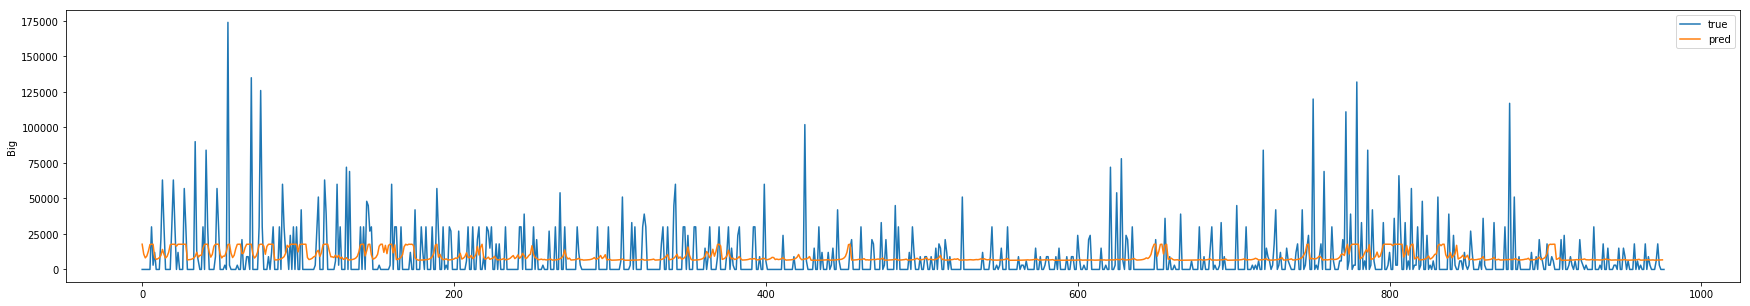

In [168]:
plot_picture()